In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re

In [2]:
review = pd.read_csv("nlp revieww.csv", encoding = 'latin-1')
review.rename(columns = {'v1': 'labels', 'v2': 'review'}, inplace = True)
#print(tweet.head())
print(review['labels'].value_counts())
review['label'] = review['labels'].map({'negative': 0, 'positive': 1})
review.drop(['labels'], axis = 1, inplace = True)
print(review.head())

positive    60
negative    38
Name: labels, dtype: int64
                                    review  label
0        I'm very happy with this subject!      1
1  The lecturer passionate in teaching NLP      1
2  Too much lab need to submit! I hate it!      0
3         She is kind in helping students.      1
4  The project task is very hard to do it.      0


In [3]:
totalReview = 60 + 38
trainIndex, testIndex = list(), list()
for i in range(review.shape[0]):
    if np.random.uniform(0, 1) < 0.75:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = review.loc[trainIndex]
testData = review.loc[testIndex]

In [4]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
print(trainData.head())
print(trainData['label'].value_counts())

testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
print(testData.head())
print(testData['label'].value_counts())

                                              review  label
0                  I'm very happy with this subject!      1
1            Too much lab need to submit! I hate it!      0
2                   She is kind in helping students.      1
3            The project task is very hard to do it.      0
4  I cannot understand all of the contents in thi...      0
1    43
0    28
Name: label, dtype: int64
                                              review  label
0            The lecturer passionate in teaching NLP      1
1  my brain.exe doesnt execute when enter in cky...      0
2  hopefully I can implement what I have learnt i...      1
3  Wah! It is unpredictable and unimagine positiv...      1
4  sometimes I wonder how the calculation can exi...      0
1    17
0    10
Name: label, dtype: int64


In [5]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [33]:
class ReviewClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.review, self.labels = trainData['review'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()    #TF-IDF 

    def calc_prob(self):
        self.prob_positive = dict()
        self.prob_negative = dict()
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        for word in self.tf_negative:
            self.prob_negative[word] = (self.tf_negative[word] + 1) / (self.negative_words + \
                                                                len(list(self.tf_negative.keys())))
        self.prob_positive_review, self.prob_negative_review = self.positive_review / self.total_review, self.negative_review / self.total_review 
        
    def calc_TF_and_IDF(self):
        noOfReview = self.review.shape[0]
        self.positive_review, self.negative_review = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_review = self.positive_review + self.negative_review
        self.positive_words = 0
        self.negative_words = 0
        self.tf_positive = dict()
        self.tf_negative = dict()
        self.idf_positive = dict()
        self.idf_negative = dict()
        for i in range(noOfReview):
            message_processed = process_message(self.review[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                else:
                    self.tf_negative[word] = self.tf_negative.get(word, 0) + 1
                    self.negative_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1
                else:
                    self.idf_negative[word] = self.idf_negative.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_positive = dict()
        self.prob_negative = dict()
        self.sum_tf_idf_positive = 0
        self.sum_tf_idf_negative = 0
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.positive_review + self.negative_review) \
                                                          / (self.idf_positive[word] + self.idf_negative.get(word, 0)))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
        for word in self.tf_negative:
            self.prob_negative[word] = (self.tf_negative[word]) * log((self.positive_review + self.negative_review) \
                                                          / (self.idf_positive.get(word, 0) + self.idf_negative[word]))
            self.sum_tf_idf_negative += self.prob_negative[word]
        for word in self.tf_negative:
            self.prob_negative[word] = (self.prob_negative[word] + 1) / (self.sum_tf_idf_negative + len(list(self.prob_negative.keys())))
            
    
        self.prob_positive_review, self.prob_negative_review = self.positive_review / self.total_review, self.negative_review / self.total_review 
                    
    def classify(self, processed_message):
        pPositive, pNegative = 0, 0
        for word in processed_message:                
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_posiitive.keys())))
            if word in self.prob_negative:
                pNegative += log(self.prob_negative[word])
            else:
                if self.method == 'tf-idf':
                    pNegative -= log(self.sum_tf_idf_negative + len(list(self.prob_negative.keys()))) 
                else:
                    pNegative -= log(self.negative_words + len(list(self.prob_negative.keys())))
            pPositive += log(self.prob_positive_review)
            pNegative += log(self.prob_negative_review)
        return pPositive >= pNegative
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result



In [34]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [35]:
sc_tf_idf = ReviewClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['review'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.68
Recall:  1.0
F1-score:  0.8095238095238095
Accuracy:  0.7037037037037037


In [38]:
def prediction(opinion):
    pm = process_message(opinion)
    print(opinion)
    print("Result:", sc_tf_idf.classify(pm))

I really love the slide
Result: True


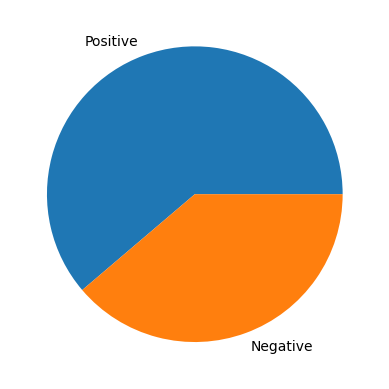

In [41]:
import matplotlib.pyplot as plt

def piechart():
    y = np.array([60, 38])
    label = ["Positive", "Negative"]

    plt.pie(y, labels = label)
    plt.show()